In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
class MeanShiftSegmentation:
    def __init__(self, bandwidth=20, max_iterations=100, convergence_threshold=0.1):
        self.bandwidth = bandwidth
        self.max_iterations = max_iterations
        self.convergence_threshold = convergence_threshold
        
    def gaussian_kernel(self, distance, bandwidth):
        return np.exp(-0.5 * (distance / bandwidth) ** 2)
    
    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2, axis=-1))
    
    def mean_shift_single_point(self, point, data):
        current_point = point.copy()
        
        for iteration in range(self.max_iterations):
            distances = self.euclidean_distance(current_point, data)
            weights = self.gaussian_kernel(distances, self.bandwidth)
            if np.sum(weights) == 0:
                break
            new_point = np.sum(data * weights.reshape(-1, 1), axis=0) / np.sum(weights)
            shift_distance = self.euclidean_distance(new_point, current_point)
            
            if shift_distance < self.convergence_threshold:
                break
                
            current_point = new_point
        return current_point
    
    def cluster_modes(self, modes, merge_threshold=None):
        if merge_threshold is None:
            merge_threshold = self.bandwidth / 2
            
        clustered_modes = []
        mode_labels = []
        
        for i, mode in enumerate(modes):
            merged = False
            
            for j, clustered_mode in enumerate(clustered_modes):
                if self.euclidean_distance(mode, clustered_mode) < merge_threshold:
                    mode_labels.append(j)
                    merged = True
                    break
                    
            if not merged:
                clustered_modes.append(mode)
                mode_labels.append(len(clustered_modes) - 1)
                
        return clustered_modes, mode_labels
    
    def segment_image(self, image, sample_ratio=0.1):
        height, width, channels = image.shape
        
        y_coords, x_coords = np.mgrid[0:height, 0:width]
        spatial_weight = self.bandwidth / 10
        
        features = np.zeros((height * width, 5))
        features[:, 0] = x_coords.flatten() * spatial_weight
        features[:, 1] = y_coords.flatten() * spatial_weight
        features[:, 2] = image[:, :, 0].flatten()
        features[:, 3] = image[:, :, 1].flatten()
        features[:, 4] = image[:, :, 2].flatten()

        n_samples = int(len(features) * sample_ratio)
        sample_indices = np.random.choice(len(features), n_samples, replace=False)
        sample_features = features[sample_indices]
        
        print(f"Finding modes for {n_samples} sample points...")
        
        modes = []
        
        for i, point in enumerate(sample_features):
            if i % (n_samples // 10) == 0:
                print(f"Processing point {i+1}/{n_samples}")
            mode = self.mean_shift_single_point(point, features)
            modes.append(mode)
        
        clustered_modes, mode_labels = self.cluster_modes(modes)
        
        print(f"Found {len(clustered_modes)} clusters")
        
        all_labels = np.zeros(len(features), dtype=int)
        
        for i, point in enumerate(features):                
            distances = [self.euclidean_distance(point, mode) for mode in clustered_modes]
            all_labels[i] = np.argmin(distances)
        
        labels = all_labels.reshape(height, width)
        
        segmented_image = np.zeros_like(image)
        for i, mode in enumerate(clustered_modes):
            mask = labels == i
            segmented_image[mask] = mode[2:5]
        
        return segmented_image


Finding modes for 3276 sample points...
Processing point 1/3276
Processing point 328/3276
Processing point 655/3276
Processing point 982/3276
Processing point 1309/3276
Processing point 1636/3276
Processing point 1963/3276
Processing point 2290/3276
Processing point 2617/3276
Processing point 2944/3276
Processing point 3271/3276
Found 37 clusters


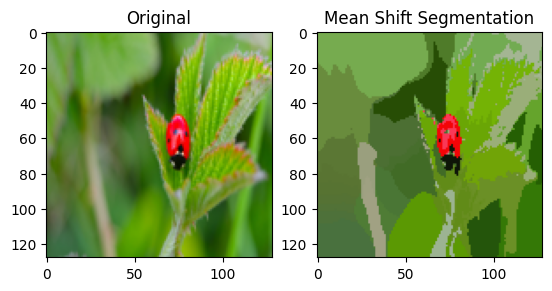

In [19]:
image = Image.open("input.webp")
image = image.resize((128, 128))
img_data = np.array(image)

ms = MeanShiftSegmentation(bandwidth=25, max_iterations=50, convergence_threshold=0.5)

segmented = ms.segment_image(img_data, sample_ratio=0.2)

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img_data)

plt.subplot(1, 2, 2)
plt.title("Mean Shift Segmentation")
plt.imshow(segmented)
plt.show()